In [93]:
from utils import CIFAR10Data, plot_costs_accuracies
import numpy as np
import scipy
import pickle
import matplotlib.pyplot as plt
import pandas as pd

## K-Layer Classifier

In [53]:
class Layer:
    def __init__(self, input_dim, output_dim, activation='relu', batch_normalisation=False, sig=0.1, dropout_thresh=None, initialisation='He'):
        if batch_normalisation:
            # initialise weights to be normally distributed with sigmas equal to sig at each layer
            if initialisation == 'He':
                print('He')
                self.W = np.random.normal(loc=0, scale=1/np.sqrt(input_dim), size=(output_dim, input_dim)) 
            else:
#                 print('initialising with sigma', sig)
                self.W = np.random.normal(loc=0, scale=sig, size=(output_dim, input_dim)) 
            self.gamma  = np.ones((output_dim, 1))
            self.beta   =  np.zeros((output_dim, 1))
            self.means_avg = None
            self.sigmas_avg = None
        else:
            # use He initialization 
            self.W = np.random.normal(loc=0, scale=1/np.sqrt(input_dim), size=(output_dim, input_dim)) 
        self.b = np.zeros((output_dim,1))
        self.activation_fn = activation # should be softmax for last layer in definition
        self.apply_bn = batch_normalisation
        self.S_hat = None # batch normalised scores (pre scale and shift)
        self.dropout_thresh = dropout_thresh # percentage of nodes to drop
        if self.dropout_thresh is not None:
            print('Applying dropout p=', 1-self.dropout_thresh)
        

        
    def activation(self, S):
        if self.activation_fn == 'relu':
            return self.relu(S) 
        elif self.activation_fn == 'softmax':
            return self.softmax(S)
        else:
            raise Exception('activation function invalid') 
    
    
    def relu(self, X):
        return np.where(X >= 0, X, 0)
    
    
    def softmax(self, X):
        return np.exp(X) / np.sum(np.exp(X), axis=0)
    
    
    def forward_pass(self, X, last_layer=False, is_train=False, alpha=0.9):
        if self.dropout_thresh is not None:
            D, N = X.shape
            indices = np.ones(D)
            number_to_zero = D*self.dropout_thresh
            indices[-int(number_to_zero):] = 0
            u1_batch = np.asarray([np.random.permutation(indices) for i in range(N)]).T
            ''' divide by p = 1-dropout_thresh = proportion of connections to keep 
                so that don't have to compensate at test'''
            u1_batch /= (1-self.dropout_thresh) 
            X = np.multiply(X, u1_batch)
            
        S = np.dot(self.W, X) 
        S += self.b
        self.S = S

        if self.apply_bn and not last_layer:
            
            if is_train:
                self.means = np.sum(S, axis=1).reshape(-1,1) / S.shape[1] 
                self.sigmas =  np.sum((S.T-self.means.T)**2, axis=0).reshape(-1,1) / S.shape[1]
                if self.means_avg is None:
                    self.means_avg = np.copy(self.means)
                    self.sigmas_avg = np.copy(self.sigmas)
                else:
                    self.means_avg = alpha * self.means_avg + (1-alpha) * self.means
                    self.sigmas_avg = alpha * self.sigmas_avg + (1-alpha) * self.sigmas
                
                assert self.means.shape == self.sigmas.shape
                means = self.means
                sigmas = self.sigmas
            else: # at test time, use averages
                means = self.means_avg 
                sigmas = self.sigmas_avg
            
            # batch normalise
            self.S_hat = (self.S - means)/(np.sqrt(sigmas+1e-10))

            S_scaled = np.multiply(self.gamma, self.S_hat) + self.beta # to do sort these out
            self.S_scaled = S_scaled
            return self.activation(S_scaled)
        else:
            return self.activation(S)
        
        
    def batch_norm_back_pass(self, G, eps=1e-10):   
        N = G.shape[1] 
        sigma1 = np.power(self.sigmas+eps, -0.5)
        sigma2 = np.power(self.sigmas+eps, -1.5)
        G1 = np.multiply(G, np.dot(sigma1,np.ones((1,N))))
        G2 = np.multiply(G, np.dot(sigma2, np.ones((1,N))))
        
        D = self.S - self.means
        c = np.dot(np.multiply(G2, D), np.ones((N,1)))
        G = G1 - np.dot(np.dot(G1,np.ones((N,1))), np.ones((1,N)))/N - np.multiply(D, np.dot(c, np.ones((1,N))))/N
                                                                       
        return G
        
    
    def update_gradients(self, eta, grad_W, grad_b, grad_gamma=None, grad_beta=None):
        self.W -= (eta * grad_W)
        self.b -= (eta * grad_b)
        if grad_gamma is not None:
            self.gamma -= (eta * grad_gamma)
        if grad_beta is not None:
            self.beta -= (eta * grad_beta)
  

In [43]:
class KLayerClassifier:
    def __init__(self, batch_size=100, eta=0.001, n_cycles=2, lamda=0, cyclical_lr=False, n_s=None, eta_min=None, eta_max=None, lr_range_test=False, dropout_thresh=None, batch_normalisation=False):
        self.batch_size = batch_size # number of images in a batch
        self.batch_normalisation = batch_normalisation
        self.lamda = lamda
        
        self.cyclical_lr = cyclical_lr
        if cyclical_lr:
            self.batch_size = 100
            self.l = 0
            self.n_s = n_s # step size
            self.eta_min = eta_min
            self.eta_max = eta_max
            self.plot_every_n_steps = int(2*n_s/10)
            self.n_cycles = n_cycles
            
        else:
            self.eta = eta
        
        if self.batch_normalisation:
            print('Performing batch normalisation', batch_normalisation)
            self.backward_pass = self.backward_pass_w_bn
            
            self.alpha = 0.9 # exponential moving average 
            
        self.lr_range_test = lr_range_test # whether to perform learning rate range test to see what eta_min and eta_max should be
        self.plot_every_n_steps = batch_size 
        self.dropout_thresh = dropout_thresh # proportion of nodes to switch off ( =(1-p) from slides)
        
        # initialise layers
        self.layers = None
    
    def __reshape(self, X):
        return X.reshape((X.shape[0],1))
        
        
    def build_model(self, input_dim, hidden_nodes, dropout_threshes=None, initialisation='He', sigma=0.01):
        if dropout_threshes is None:
            dropout_threshes = [None]*len(hidden_nodes)

        self.add_layer(input_dim=input_dim, output_dim=hidden_nodes[0], dropout_thresh=dropout_threshes[0], \
                       initialisation=initialisation, sigma=sigma)

        for i, h in enumerate(hidden_nodes[:-1]):
            self.add_layer(input_dim=hidden_nodes[i], output_dim=hidden_nodes[i+1], \
                           dropout_thresh=dropout_threshes[i], initialisation=initialisation, sigma=sigma)
    
        # last layer with output dim number of classes
        self.add_layer(input_dim=hidden_nodes[-1], output_dim=10, activation='softmax', initialisation=initialisation, sigma=sigma)
        
        
    def add_layer(self, input_dim, output_dim, activation='relu', dropout_thresh=None, initialisation='He', sigma=0.01):
        # add a new layer
        if self.layers is None:
            self.layers = []
        self.layers.append(Layer(input_dim, output_dim, activation, batch_normalisation=self.batch_normalisation, \
                                 dropout_thresh=dropout_thresh, initialisation=initialisation, sig=sigma))
        

    def normalise(self, train_X, val_X, test_X):
        ''' X has shape (d,n) where d = dimensionality of each image, n is number of images '''
        mean = np.mean(train_X, axis=1)
        std = np.std(train_X, axis=1)
        original_shape = train_X.shape
        # apply same transformation to all of the datasets using params from train set
        def _normalise_helper(a, m, s):
            return ((a.T - m.T) / s.T).T
        
        train_X = _normalise_helper(train_X, mean, std)
        val_X = _normalise_helper(val_X, mean, std)
        test_X = _normalise_helper(test_X, mean, std)
        return train_X, val_X, test_X

    
    def forward_pass(self, X, is_train=True):
        H = np.copy(X)
        Xs = [X]

        for layer in self.layers[:-1]: # loop layers 1...k-1
            H = layer.forward_pass(H, is_train=is_train)
            Xs.append(H)
        # apply softmax to last layer instead of relu
        last_layer = self.layers[-1]
        P = last_layer.forward_pass(H, last_layer=True, is_train=is_train)
        assert len(Xs) == len(self.layers) # k
        return Xs, P
    
    
    def compute_accuracy(self, X, Y):
        ''' X is data (dim, N), y is gt (C, N), W is weight matrix, b is bias, Y is 1hot encoded labels'''
        _, P = self.forward_pass(X, is_train=False)
        pred = np.argmax(P, axis=0)
        lbls = np.argmax(Y, axis=0)
        accuracy = np.mean(pred == lbls)
        return pred, accuracy
    

    def compute_cost(self, X, Y): # TODO
        ''' 
            X: dxn (dimensionality by # images)
            Y: Kxn (no. classes one-hot encoded by # images)
            J: scalar corresponding to sum of loss of ntwks predictions of X relative to gt labels 
        '''
        _, P = self.forward_pass(X)
        N = X.shape[1]
        loss = -np.sum(Y*np.log(P)) / N
        
        regularisation_term = 0
        for layer in self.layers:
            regularisation_term += np.sum(layer.W**2)
        
        cost = loss + self.lamda * regularisation_term
    
        return loss, cost
        
    
    def backward_pass(self, Xs, Y, P):
        G = -(Y - P)
        N = G.shape[1]
        k = len(self.layers)
        
        grad_Ws = []
        grad_bs = []
        
        for l in range(k-1, 0, -1): # propagate gradient backwarsd to first layer 
            layer = self.layers[l]
            H = Xs[l] # previous layers X (index at l due to appending input at start for first layer in forward pass)
            grad_W = np.dot(G, H.T) / N + 2 * self.lamda * layer.W 
            grad_b = self.__reshape(np.sum(G, axis=1) / N)

            grad_Ws.append(grad_W)
            grad_bs.append(grad_b)
            G = np.dot(layer.W.T, G)
            Ind = H > 0
            G = np.multiply(G, Ind)
            
        # For first layer
        layer = self.layers[0]
        grad_W = np.dot(G, Xs[0].T) / N + 2 * self.lamda * layer.W 
        grad_b = self.__reshape(np.sum(G, axis=1) / N)
        grad_Ws.append(grad_W)
        grad_bs.append(grad_b)
        
        # reverse order from first layer to last
        return grad_Ws[::-1], grad_bs[::-1], [None]*len(self.layers), [None]*len(self.layers)
    

    def backward_pass_w_bn(self, Xs, Y, P):
        G = -(Y - P)

        N = G.shape[1]
        k = len(self.layers)
        H = Xs[-1]
        
        # last layer doesn't have batch normalisation
        layer = self.layers[-1]
        
        grad_W = np.dot(G, H.T) / N + 2*self.lamda * layer.W
        grad_b = self.__reshape(np.sum(G, axis=1) / N)
        
        grad_Ws = [grad_W]
        grad_bs = [grad_b]
        grad_gammas = [None]
        grad_betas = [None]
        
        
        for l in range(k-2, -1, -1): # propagate gradient backwarsd to first layer from layers k-1 to 0
            layer = self.layers[l]
            
            # Propagate G to current layer
            G = np.dot(self.layers[l+1].W.T, G)
            G = np.multiply(G, H>0)
            
            H = Xs[l]
            # compute gradient for scale and offset parameters
            grad_gamma = np.dot(np.multiply(G, layer.S_hat), np.ones((N,1))) / N 
            grad_beta  = np.dot(G, np.ones((N,1))) / N
            # propagate gradients through scale and shift
            G = np.multiply(G, layer.gamma)
            # propagate G through batch normalisation
            G = layer.batch_norm_back_pass(G)  
            
            # calculate gradients of J wrt bias and weights
            grad_W = np.dot(G, H.T) / N 
            
            grad_W += (2 * self.lamda * layer.W )
            grad_b = self.__reshape(np.sum(G, axis=1) / N)
            
            grad_Ws.append(grad_W)
            grad_bs.append(grad_b)
            grad_gammas.append(grad_gamma)
            grad_betas.append(grad_beta)
            
   
        # reverse order from first layer to last
        return grad_Ws[::-1], grad_bs[::-1], grad_gammas[::-1], grad_betas[::-1] 
    
    
    def compute_gradients(self, X, Y):
        ''' computes gradients of the cost function wrt W and b for batch X '''
        N = X.shape[1]

        # forward pass, apply dropout if its set
        Xs, P = self.forward_pass(X)
        
        # backward pass
        grad_Ws, grad_bs, grad_gammas, grad_betas = self.backward_pass(Xs, Y, P)
        
        return grad_Ws, grad_bs, grad_gammas, grad_betas
    
        
        
    def train(self, X, Y, random_shuffle=False, val_X=None, val_Y=None, get_accuracies_costs=False, max_lr=0.1, n_epochs=20, apply_jitter=False):
        n = X.shape[1]
        
        number_of_batches = int(n / self.batch_size)
        
        assert number_of_batches > 0
        indices = np.arange(X.shape[1])
        if random_shuffle:
            print('Randomly shuffling')
            
        if apply_jitter:
            print('Adding jitter')
        
        if self.cyclical_lr:
            print('Cyclical learning rate')
            n_epochs = int(self.n_s * 2 * self.n_cycles / number_of_batches)
       
        accuracies = {'train': [], 'val': []}
        costs = {'train': [], 'val': []}
        losses = {'train': [], 'val': []}
        update_steps = []
        
        eta = self.eta if not self.cyclical_lr else self.eta_min
        t = 0 # each update step % 2*n_s
    
        if self.lr_range_test:
            eta = 0
            self.plot_every_n_step = int(n_epochs * number_of_batches / 20)
            eta_incr = max_lr * self.plot_every_n_step / (n_epochs * number_of_batches)
            
        print('total epochs', n_epochs)
        for epoch in range(n_epochs):  
            if epoch % 10 == 0:
                print('epoch', epoch)
            if random_shuffle:
                np.random.shuffle(indices)
                X = np.take(X, indices, axis=1)
                Y = np.take(Y, indices, axis=1)
                
            for j in range(number_of_batches):
                if self.cyclical_lr:  
                    t_mod = t % (2*self.n_s)
                    if t_mod <= self.n_s:
                        eta = self.eta_min + t_mod/self.n_s * (self.eta_max - self.eta_min)

                    elif t_mod <= 2*self.n_s:
                        eta = self.eta_max - (t_mod - self.n_s)/self.n_s * (self.eta_max - self.eta_min)
   

                j_start = j * self.batch_size
                j_end = (j+1) * self.batch_size
                Xbatch = X[:, j_start:j_end]
                Ybatch = Y[:, j_start:j_end]
                
                if apply_jitter:
                    Xbatch = add_jitter(Xbatch)
                
                # Perform MiniBatch Gradient Descent
                grad_Ws, grad_bs, grad_gammas, grad_betas = self.compute_gradients(Xbatch, Ybatch)
                
                for i in range(len(self.layers)): 
                    self.layers[i].update_gradients(eta, grad_Ws[i], grad_bs[i], grad_gammas[i], grad_betas[i]) 

                if get_accuracies_costs and (t % self.plot_every_n_steps == 0):
                    _, train_accuracy = self.compute_accuracy(X, Y)
                    _, val_accuracy = self.compute_accuracy(val_X, val_Y)
                    accuracies['train'].append(train_accuracy)
                    accuracies['val'].append(val_accuracy)
                    train_loss, train_cost = self.compute_cost(X, Y)
                    val_loss, val_cost = self.compute_cost(val_X, val_Y)
                    costs['train'].append(train_cost)
                    costs['val'].append(val_cost)
                    losses['train'].append(train_loss)
                    losses['val'].append(val_loss)
                    update_steps.append(t)
            
                
                if self.lr_range_test and (t % self.plot_every_n_step == 0):
                    update_steps.append(eta)
                    _, train_accuracy = self.compute_accuracy(X, Y)
                    _, val_accuracy = self.compute_accuracy(val_X, val_Y)
                    accuracies['train'].append(train_accuracy)
                    accuracies['val'].append(val_accuracy)
                    eta += eta_incr
                    
                t += 1

        return accuracies, losses, costs, update_steps
 

Let's check gradients are correct for 2/3/4 layer classifiers

In [17]:
def compute_grads_num(clf, X, Y, lamda=0, h=1e-5):
    grad_Ws = []
    grad_bs = []
    grad_gammas = []
    grad_betas = []
    number_layers = len(clf.layers)
    
    for layer in clf.layers:
        grad_Ws.append(np.zeros(layer.W.shape))
        grad_bs.append(np.zeros(layer.b.shape))
        if layer.apply_bn:
            grad_gammas.append(np.zeros(layer.gamma.shape))
            grad_betas.append(np.zeros(layer.beta.shape))
    
    
    D = X.shape[0]
    
    for l, layer in enumerate(clf.layers):
        for i in range(len(layer.b)):
            b = np.copy(layer.b)
            b_try = np.array(layer.b)
            b_try[i] -= h
            layer.b = b_try
            _, c1 = clf.compute_cost(X, Y)
            b_try = np.array(b)
            b_try[i] += h
            layer.b = b_try
            _, c2 = clf.compute_cost(X, Y)
            grad_bs[l][i] = (c2-c1) / (2*h)
            layer.b = b
       
    
    for l, layer in enumerate(clf.layers):
        for i in range(layer.W.shape[0]):
            for j in range(layer.W.shape[1]):
                W = np.copy(layer.W)
                W_try = np.array(layer.W)
                W_try[i,j] -= h
                layer.W = W_try
                _, c1 = clf.compute_cost(X, Y)
                W_try = np.array(W)
                W_try[i,j] += h
                layer.W = W_try
                _, c2 = clf.compute_cost(X, Y)
                grad_Ws[l][i,j] = (c2-c1) / (2*h)
                layer.W = W
            
    
    if clf.batch_normalisation:
        for l, layer in enumerate(clf.layers[:-1]):
            for i in range(len(layer.gamma)):
                gamma = np.copy(layer.gamma)
                gamma_try = np.array(layer.gamma)
                gamma_try[i] -= h
                layer.gamma = gamma_try
                _, c1 = clf.compute_cost(X, Y)
                gamma_try = np.array(gamma)
                gamma_try[i] += h
                layer.gamma = gamma_try
                _, c2 = clf.compute_cost(X, Y)
                grad_gammas[l][i] = (c2-c1) / (2*h)
                layer.gamma = gamma
    
        for l, layer in enumerate(clf.layers[:-1]):
            for i in range(len(layer.beta)):
                beta = np.copy(layer.beta)
                beta_try = np.array(layer.beta)
                beta_try[i] -= h
                layer.beta = beta_try
                _, c1 = clf.compute_cost(X, Y)
                beta_try = np.array(beta)
                beta_try[i] += h
                layer.beta = beta_try
                _, c2 = clf.compute_cost(X, Y)
                grad_betas[l][i] = (c2-c1) / (2*h)
                layer.beta = beta

    return grad_Ws, grad_bs, grad_gammas, grad_betas



def check_gradients_are_equal(clf, X_train, Y_train_1hot, num_samples=20):
    # choose random subset of num_samples to test on
    indices = np.arange(X_train.shape[1])
    np.random.shuffle(indices)
    indices = indices[:num_samples]
  
    X_a = np.take(X_train, indices, axis=1)
    Y_a = np.take(Y_train_1hot, indices, axis=1)
    X_n = np.copy(X_a)
    Y_n = np.copy(Y_a)
    
    weights_copies = []
    bias_copies = []
    gammas_copies = []
    betas_copies = []
    for i, layer in enumerate(clf.layers):
        weights_copies.append(np.copy(layer.W))
        bias_copies.append(np.copy(layer.b))
        if layer.apply_bn and i < len(clf.layers)-1:
            gammas_copies.append(np.copy(layer.gamma))
            betas_copies.append(np.copy(layer.beta))
        
    grad_Ws, grad_bs, grad_gammas, grad_betas = clf.compute_gradients(X_a, Y_a)
    
    # reset params
    for i, layer in enumerate(clf.layers):
        layer.W = weights_copies[i]
        layer.b = bias_copies[i]
        
    grad_Ws_num, grad_bs_num, grad_gammas_num, grad_betas_num = compute_grads_num(clf, X_n, Y_n)
    
    def compare_gradients(g_n, g_a, eps=0.000001):
#         print('numerical', g_n)
#         print('analytical', g_a)
        err = np.linalg.norm(g_a-g_n) / max(eps, np.linalg.norm(g_a) + np.linalg.norm(g_n))
        print('relative error', err)
        print('err < 10**-6', err < 10**-6)
        return err

    # check whether they're similar
    err_Ws = []
    err_bs = []
    err_betas = []
    err_gammas = []
    for i, layer in enumerate(clf.layers):
        print('W gradients')
        err_Ws.append(compare_gradients(grad_Ws_num[i], grad_Ws[i]))
        print('b gradients')
        err_bs.append(compare_gradients(grad_bs_num[i], grad_bs[i]))
        
        print(clf.batch_normalisation)
        if clf.batch_normalisation and i < len(clf.layers)-1:
                print('Gamma gradients')
                err_gammas.append(compare_gradients(grad_gammas_num[i], grad_gammas[i]))
                print('Beta gradients')
                err_betas.append(compare_gradients(grad_betas_num[i], grad_betas[i]))
    return err_Ws, err_bs, err_betas, err_gammas
    

In [94]:
# load in data for checking gradients
CIFARDATA = CIFAR10Data(dataset_dir='../datasets/cifar-10-batches-py/')
train_X, train_Y = CIFARDATA.load_batch('data_batch_1')
val_X, val_Y = CIFARDATA.load_batch('data_batch_2')
test_X, test_Y = CIFARDATA.load_batch('test_batch')
X = train_X[:10,:] # take 10 dimensions
input_dim = X.shape[0]

In [13]:
# 2 layer classifier gradients with no batch normalisation
n_s = 5 * 45000 / 100
model = KLayerClassifier(batch_size=100, eta=0.005, n_cycles=2, lamda=.005, cyclical_lr=True, n_s=n_s, eta_min=10**-5, eta_max=0.1)
train_X, val_X, test_X = model.normalise(train_X, val_X, test_X)
hidden_nodes = [50]
model.build_model(input_dim, hidden_nodes)
check_gradients_are_equal(model, X, train_Y, num_samples=100)

W gradients
relative error 1.3565468200080613e-10
err < 10**-6 True
b gradients
relative error 0.008589039611428382
err < 10**-6 False
W gradients
relative error 6.677768024543705e-09
err < 10**-6 True
b gradients
relative error 1.4456980983835945e-09
err < 10**-6 True


In [49]:
# 3 layer classifier gradients with no batch normalisation
n_s = 5 * 45000 / 100
model = KLayerClassifier(batch_size=100, eta=0.005, n_cycles=2, lamda=.005, cyclical_lr=True, n_s=n_s, eta_min=10**-5, eta_max=0.1)
train_X, val_X, test_X = model.normalise(train_X, val_X, test_X)
hidden_nodes = [10, 10]
model.build_model(input_dim, hidden_nodes)
check_gradients_are_equal(model, X, train_Y, num_samples=100)

W gradients
relative error 4.677367086846267e-10
err < 10**-6 True
b gradients
relative error 3.1830700613930595e-10
err < 10**-6 True
W gradients
relative error 3.1535890514208995e-10
err < 10**-6 True
b gradients
relative error 2.4303945402157414e-10
err < 10**-6 True
W gradients
relative error 3.2359068967437383e-10
err < 10**-6 True
b gradients
relative error 2.1769764979386327e-10
err < 10**-6 True


In [10]:
# 4 layer classifier gradients with no batch normalisation
n_s = 5 * 45000 / 100
model = KLayerClassifier(batch_size=100, eta=0.005, n_cycles=2, lamda=.005, cyclical_lr=True, n_s=n_s, eta_min=10**-5, eta_max=0.1)
train_X, val_X, test_X = model.normalise(train_X, val_X, test_X)
hidden_nodes = [10, 10, 10]
model.build_model(input_dim, hidden_nodes)
check_gradients_are_equal(model, X, train_Y, num_samples=100)

W gradients
relative error 1.4880601439955964e-11
err < 10**-6 True
b gradients
relative error 2.444843045048922e-09
err < 10**-6 True
W gradients
relative error 1.1374741920941868e-11
err < 10**-6 True
b gradients
relative error 1.2799111925430422e-09
err < 10**-6 True
W gradients
relative error 1.3157496743218651e-11
err < 10**-6 True
b gradients
relative error 3.1058382647345083e-10
err < 10**-6 True
W gradients
relative error 2.991700611764966e-11
err < 10**-6 True
b gradients
relative error 7.401307838932298e-10
err < 10**-6 True


In [29]:
# 4 layer classifier gradients with no batch normalisation
n_s = 5 * 45000 / 100
model = KLayerClassifier(batch_size=100, eta=0.005, n_cycles=2, lamda=.005, cyclical_lr=True, n_s=n_s, eta_min=10**-5, eta_max=0.1, batch_normalisation=True)
train_X, val_X, test_X = model.normalise(train_X, val_X, test_X)
hidden_nodes = [10, 10, 10]
model.build_model(input_dim, hidden_nodes)
err_Ws, err_bs, err_betas, err_gammas = check_gradients_are_equal(model, X, train_Y, num_samples=100)

Performing batch normalisation True
W gradients
relative error 8.747006524857282e-10
err < 10**-6 True
b gradients
relative error 9.611767227878158e-13
err < 10**-6 True
True
Gamma gradients
relative error 2.8636761661471595e-10
err < 10**-6 True
Beta gradients
relative error 3.371212903694867e-10
err < 10**-6 True
W gradients
relative error 2.69926489791981e-09
err < 10**-6 True
b gradients
relative error 9.216737814900337e-11
err < 10**-6 True
True
Gamma gradients
relative error 5.769093555089888e-10
err < 10**-6 True
Beta gradients
relative error 1.0820446498575388e-09
err < 10**-6 True
W gradients
relative error 2.140440409800398e-09
err < 10**-6 True
b gradients
relative error 4.24667428579559e-11
err < 10**-6 True
True
Gamma gradients
relative error 6.749964890481744e-10
err < 10**-6 True
Beta gradients
relative error 1.0254248030202147e-09
err < 10**-6 True
W gradients
relative error 3.096329878970964e-10
err < 10**-6 True
b gradients
relative error 3.6484450696169533e-10
err < 

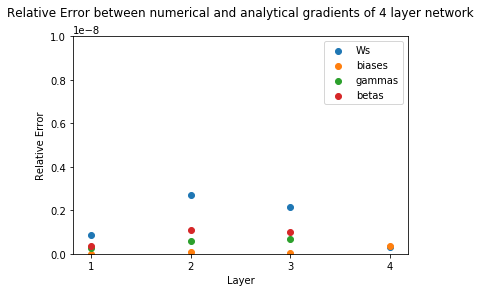

In [36]:
plt.scatter([i+1 for i in range(4)], err_Ws, label='Ws')
plt.scatter([i+1 for i in range(4)], err_bs, label='biases')
plt.scatter([i+1 for i in range(3)], err_gammas, label='gammas')
plt.scatter([i+1 for i in range(3)], err_betas, label='betas')
plt.ylim([0, 10**-8])
plt.xlabel('Layer')
plt.ylabel('Relative Error')
plt.title('Relative Error between numerical and analytical gradients of 4 layer network', pad=20)
plt.xticks([1,2,3,4])
plt.legend()

In [95]:
# load in all data
train_X, train_Y = CIFARDATA.load_batches(['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4'])
val_X, val_Y = CIFARDATA.load_batch('data_batch_5')
train_X = np.hstack((train_X, val_X[:,:5000]))
train_Y = np.hstack((train_Y, val_Y[:,:5000]))
val_X = val_X[:,5000:]
val_Y = val_Y[:,5000:]
test_X, test_Y = CIFARDATA.load_batch('test_batch')
datasets = [train_X, train_Y, val_X, val_Y, test_X , test_Y]

In [6]:
def train_model(params, datasets, plot_acc_costs=False):
    train_X, train_Y, val_X, val_Y, test_X , test_Y = datasets
    n_classes = 10
    input_dim = train_X.shape[0]
    random_shuffle = True

    dropouts = params['dropouts'] if 'dropouts' in params else None

    if 'eta' in params:
            clf = KLayerClassifier(batch_size=params['batch_size'], \
                           lamda=params['lamda'], cyclical_lr=False, \
                           eta=params['eta'], \
                           batch_normalisation=params['batch_normalisation'])
    else:
        clf = KLayerClassifier(batch_size=params['batch_size'], n_cycles=params['n_cycles'], \
                           lamda=params['lamda'], cyclical_lr=True, n_s=params['n_s'], \
                           eta_min=params['eta_min'], eta_max=params['eta_max'], \
                           batch_normalisation=params['batch_normalisation'])
    clf.build_model(input_dim, params['hidden_nodes'], dropout_threshes=dropouts)
        
    train_X, val_X, test_X = clf.normalise(train_X, val_X, test_X)
    apply_jitter = params['apply_jitter'] if 'apply_jitter' in params else False
    
    
    if 'n_epochs' in params:
        accuracies, losses, costs, update_steps = clf.train(train_X, train_Y, random_shuffle, n_epochs=params['n_epochs'], get_accuracies_costs=plot_acc_costs, 
                                  val_X = val_X, val_Y = val_Y, apply_jitter=apply_jitter)
    else:
        accuracies, losses, costs, update_steps = clf.train(train_X, train_Y, random_shuffle, get_accuracies_costs=plot_acc_costs, 
                                  val_X = val_X, val_Y = val_Y, apply_jitter=apply_jitter)
        
    if plot_acc_costs:
        plot_costs_accuracies(accuracies, losses, costs, update_steps)

    _, test_accuracy = clf.compute_accuracy(test_X, test_Y) # use lables to compute accuracy
    _, val_accuracy = clf.compute_accuracy(val_X, val_Y)
    print('test_accuracy', test_accuracy)
    return {'test_accuracy': test_accuracy, 'val_accuracy': val_accuracy}


3-layer network

Randomly shuffling
Cyclical learning rate
total epochs 20
epoch 0
epoch 10


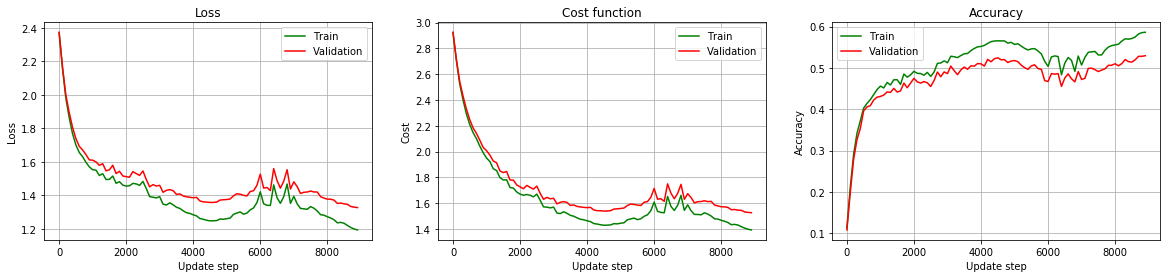

test_accuracy 0.5239


{'test_accuracy': 0.5239, 'val_accuracy': 0.5298}

In [101]:
params = {'lamda': 0.005, 'n_cycles':  2, 'batch_size': 100, 'hidden_nodes': [50, 50],
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 5 * 45000 / 100, 'batch_normalisation': False}
train_model(params, datasets, plot_acc_costs=True)

9-layer network

Randomly shuffling
Cyclical learning rate
total epochs 20
epoch 0
epoch 10


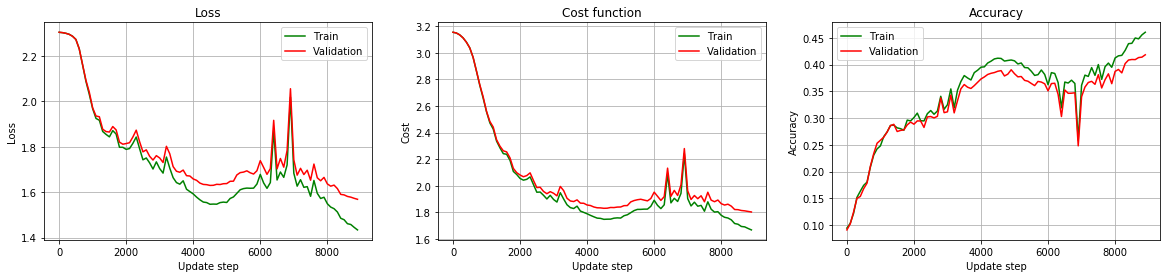

test_accuracy 0.4164


{'test_accuracy': 0.4164, 'val_accuracy': 0.4232}

In [98]:
params = {'lamda': 0.005, 'n_cycles':  2, 'batch_size': 100, 'batch_normalisation': False, \
          'hidden_nodes': [50, 30, 20, 20, 10, 10, 10, 10], \
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 5 * 45000 / 100}
train_model(params, datasets, plot_acc_costs=True)

## Batch normalisation

We see that it is hard to train a deeper network well and performance drops with 9 layers. We will apply batch normalisation as a way to overcome this.

What happens when we use batch normalisation on the 3 layer network?

Performing batch normalisation True
He
He
He
Randomly shuffling
Cyclical learning rate
total epochs 20
epoch 0
epoch 10


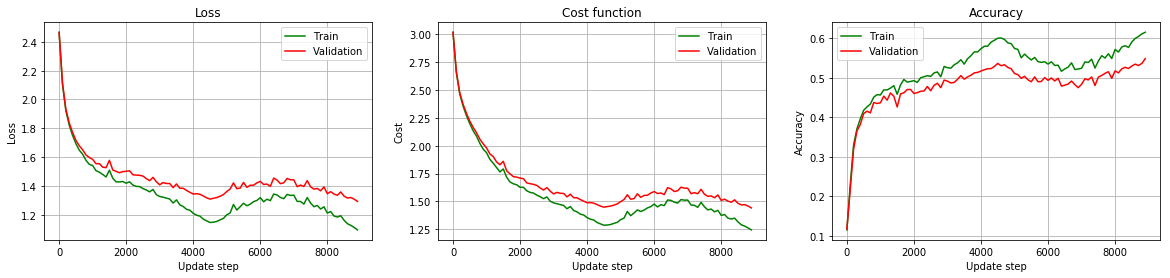

test_accuracy 0.5333


{'test_accuracy': 0.5333, 'val_accuracy': 0.5446}

In [100]:
params = {'lamda': 0.005, 'n_cycles':  2, 'batch_size': 100, 'hidden_nodes': [50, 50],
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 5 * 45000 / 100, 'batch_normalisation': True}
train_model(params, datasets, plot_acc_costs=True)

### Coarse-to-fine search for lambda for 3-layer network`

In [181]:
test_results = []

l = -5
while l <= -1:
    print(l)
    params = {'lamda': 10**l, 'l': l, 'n_cycles':  2, 'batch_size': 100, 'hidden_nodes': [50, 50],
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 5 * 45000 / 100, 'batch_normalisation': True}
    res = train_model(params, datasets, plot_acc_costs=False)
    test_results.append({**params, **res})
    l += 0.5

import pandas as pd
df_coarse_search = pd.DataFrame(test_results).sort_values(by=['test_accuracy', 'val_accuracy'], ascending=False)
df_coarse_search.to_csv('coarse_search.csv')
df_coarse_search

-5
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5042
-4.5
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5054
-4.0
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5125
-3.5
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5061
-3.0
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.518
-2.5
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5306
-2.0
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5322
-1.5
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5126
-1.0
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.4925


,batch_normalisation,batch_size,eta_max,eta_min,hidden_nodes,l,lamda,n_cycles,n_s,test_accuracy,val_accuracy
6,True,100,0.1,0.00001,"[50, 50]",-2.0,0.010000,2,2250.0,0.5322,0.5386
5,True,100,0.1,0.00001,"[50, 50]",-2.5,0.003162,2,2250.0,0.5306,0.5514
4,True,100,0.1,0.00001,"[50, 50]",-3.0,0.001000,2,2250.0,0.5180,0.5314
7,True,100,0.1,0.00001,"[50, 50]",-1.5,0.031623,2,2250.0,0.5126,0.5182
2,True,100,0.1,0.00001,"[50, 50]",-4.0,0.000100,2,2250.0,0.5125,0.5098
3,True,100,0.1,0.00001,"[50, 50]",-3.5,0.000316,2,2250.0,0.5061,0.5258
1,True,100,0.1,0.00001,"[50, 50]",-4.5,0.000032,2,2250.0,0.5054,0.5158
0,True,100,0.1,0.00001,"[50, 50]",-5.0,0.000010,2,2250.0,0.5042,0.5188
8,True,100,0.1,0.00001,"[50, 50]",-1.0,0.100000,2,2250.0,0.4925,0.4862


In [182]:
# random search, running in refined interval
import random

results = []

# we use the range for lambda that had the highest accuracy in the coarse search
l_min = -2.5 # TODO 
l_max = -2.0

for x in range(10):
    l = l_min + (l_max - l_min)*random.uniform(0, 1)
    params = {'batch_size': 100, 'hidden_nodes': [50, 50], 'n_cycles': 2, 'batch_normalisation': True,
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 5 * 45000 / 100, 'lamda': 10**l, 'l': l}
    res = train_model(params, datasets, plot_acc_costs=False)
    results.append({**params, **res})
    
df_random_search = pd.DataFrame(results).sort_values(by=['test_accuracy', 'val_accuracy'], ascending=False)
df_random_search.to_csv('random_search.csv')
df_random_search

Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5321
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5349
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5349
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5363
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5347
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5361
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5396
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5305
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5352
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5329


,batch_normalisation,batch_size,eta_max,eta_min,hidden_nodes,l,lamda,n_cycles,n_s,test_accuracy,val_accuracy
6,True,100,0.1,0.00001,"[50, 50]",-2.448857,0.003557,2,2250.0,0.5396,0.5352
3,True,100,0.1,0.00001,"[50, 50]",-2.142757,0.007199,2,2250.0,0.5363,0.5460
5,True,100,0.1,0.00001,"[50, 50]",-2.376905,0.004199,2,2250.0,0.5361,0.5354
8,True,100,0.1,0.00001,"[50, 50]",-2.328884,0.004689,2,2250.0,0.5352,0.5426
2,True,100,0.1,0.00001,"[50, 50]",-2.488304,0.003249,2,2250.0,0.5349,0.5526
1,True,100,0.1,0.00001,"[50, 50]",-2.168261,0.006788,2,2250.0,0.5349,0.5452
4,True,100,0.1,0.00001,"[50, 50]",-2.244317,0.005697,2,2250.0,0.5347,0.5504
9,True,100,0.1,0.00001,"[50, 50]",-2.243185,0.005712,2,2250.0,0.5329,0.5428
0,True,100,0.1,0.00001,"[50, 50]",-2.479225,0.003317,2,2250.0,0.5321,0.5416
7,True,100,0.1,0.00001,"[50, 50]",-2.137384,0.007288,2,2250.0,0.5305,0.5474


In [183]:
# one more round of refined random search
import random

results = []

# we use the range for lambda that had the highest accuracy in the coarse search
l_min = -2.449 # TODO 
l_max = -2.143

for x in range(20):
    l = l_min + (l_max - l_min)*random.uniform(0, 1)
    params = {'batch_size': 100, 'hidden_nodes': [50, 50], 'n_cycles': 2, 'batch_normalisation': True,
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 5 * 45000 / 100, 'lamda': 10**l, 'l': l}
    res = train_model(params, datasets, plot_acc_costs=False)
    results.append({**params, **res})
    
df_random_ref_search = pd.DataFrame(results).sort_values(by=['test_accuracy', 'val_accuracy'], ascending=False)
df_random_ref_search.to_csv('random_search_refined.csv')
df_random_ref_search

Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.532
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5371
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5337
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5362
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.537
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5306
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5385
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5302
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5355
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
test_accuracy 0.5339
Performing b

,batch_normalisation,batch_size,eta_max,eta_min,hidden_nodes,l,lamda,n_cycles,n_s,test_accuracy,val_accuracy
6,True,100,0.1,0.00001,"[50, 50]",-2.175910,0.006669,2,2250.0,0.5385,0.5434
17,True,100,0.1,0.00001,"[50, 50]",-2.446686,0.003575,2,2250.0,0.5374,0.5480
1,True,100,0.1,0.00001,"[50, 50]",-2.317203,0.004817,2,2250.0,0.5371,0.5370
4,True,100,0.1,0.00001,"[50, 50]",-2.441083,0.003622,2,2250.0,0.5370,0.5502
19,True,100,0.1,0.00001,"[50, 50]",-2.431646,0.003701,2,2250.0,0.5370,0.5434
3,True,100,0.1,0.00001,"[50, 50]",-2.378998,0.004178,2,2250.0,0.5362,0.5486
8,True,100,0.1,0.00001,"[50, 50]",-2.399972,0.003981,2,2250.0,0.5355,0.5514
14,True,100,0.1,0.00001,"[50, 50]",-2.384040,0.004130,2,2250.0,0.5346,0.5472
10,True,100,0.1,0.00001,"[50, 50]",-2.294322,0.005078,2,2250.0,0.5341,0.5420
12,True,100,0.1,0.00001,"[50, 50]",-2.177114,0.006651,2,2250.0,0.5340,0.5392


Performing batch normalisation True
Randomly shuffling
Cyclical learning rate


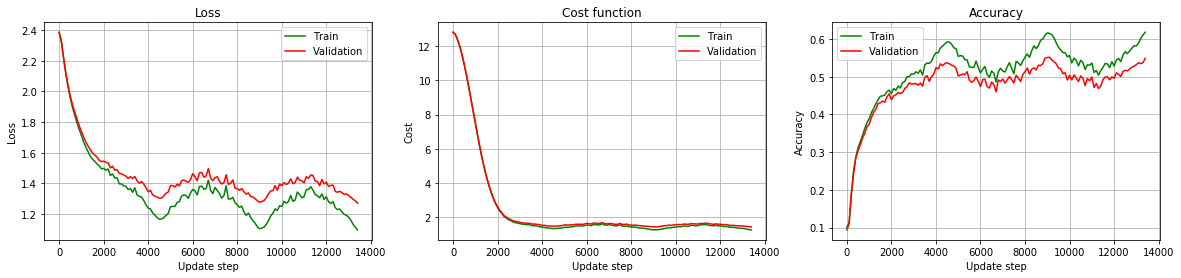

test_accuracy 0.5397


{'test_accuracy': 0.5397, 'val_accuracy': 0.5514}

In [184]:
# check performance for more cycles (3) with optimal lambda
params = {'lamda': 0.006669, 'n_cycles':  3, 'batch_size': 100, 'hidden_nodes': [50, 50],
	          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 5 * 45000 / 100, 'batch_normalisation': True}
train_model(params, datasets, plot_acc_costs=True)

### 9-layer network 

We train the 9-layer network with the same hyperparameter settings as the 3-layer network. 

Performing batch normalisation True
Randomly shuffling
Cyclical learning rate


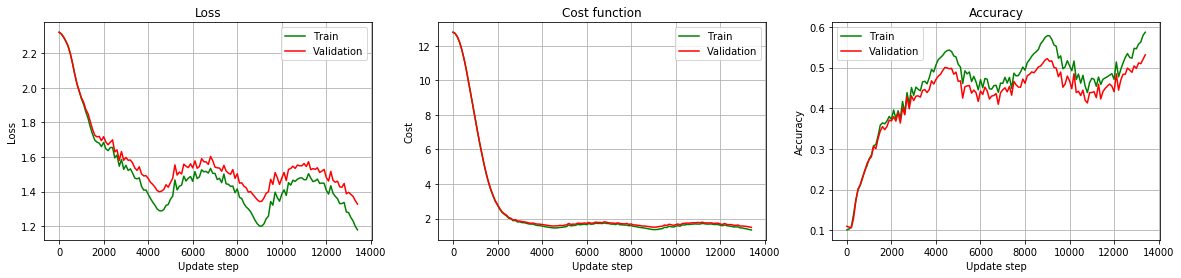

test_accuracy 0.5221


{'test_accuracy': 0.5221, 'val_accuracy': 0.5348}

In [186]:
params = {'lamda': 0.006669, 'n_cycles':  3, 'batch_size': 100, 'batch_normalisation': True, \
          'hidden_nodes': [50, 30, 20, 20, 10, 10, 10, 10], \
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 5 * 45000 / 100}
train_model(params, datasets, plot_acc_costs=True)

### Investigating using higher learning rates with batch normalisation

The frequently stated pros of batch normalization are that training becomes more stable, higher learning rates can be used as opposed to when batch normalization is not used and it acts as a form of regularization. Let us explore whether this is true.

In [78]:
# increase learning rate
results = []
learning_rates = [10**-l for l in range(1,6)]
# for lr in learning_rates:
#     print('lr', lr)
#     params = {'n_epochs':  n_epochs, 'batch_size': 100,  'batch_normalisation': True,\
#                   'hidden_nodes': [50, 50], 'eta': lr, 'lamda': 0.006669, 'epochs': 20}
#     res = train_model(params, datasets, plot_acc_costs=False)
#     results.append({**params, **res})

# df_lr = pd.DataFrame(results).sort_values(by=['test_accuracy', 'val_accuracy'], ascending=False)
# df_lr.to_csv('lr_batch_normalisation.csv')
# df_lr = pd.read_csv('lr_batch_normalisation.csv')
# df_lr.sort_values(by=['test_accuracy'], ascending=True)

results = []
for lr in learning_rates:
    print('lr', lr)
    params = {'batch_size': 100,  'batch_normalisation': False,\
                  'hidden_nodes': [50, 50], 'eta': lr, 'lamda': 0.006669, 'epochs': 20}
    res = train_model(params, datasets, plot_acc_costs=False)
    results.append({**params, **res})

df_lr_no_bn = pd.DataFrame(results).sort_values(by=['test_accuracy', 'val_accuracy'], ascending=False)
df_lr_no_bn.to_csv('lr_no_batch_normalisation.csv')
# df_lr = pd.read_csv('lr_batch_normalisation.csv')
# df_lr.sort_values(by=['test_accuracy'], ascending=True)

# y = list(df_lr['test_accuracy'])
# x = list(df_lr['eta'])
# plt.plot(x, y)
# plt.xlabel('Lamda')
# plt.ylabel('Test Accuracy')  
# plt.legend()


lr 0.1
Randomly shuffling
total epochs 20
epoch 0
epoch 10
test_accuracy 0.4948
lr 0.01
Randomly shuffling
total epochs 20
epoch 0
epoch 10
test_accuracy 0.5047
lr 0.001
Randomly shuffling
total epochs 20
epoch 0
epoch 10
test_accuracy 0.4374
lr 0.0001
Randomly shuffling
total epochs 20
epoch 0
epoch 10
test_accuracy 0.3023
lr 1e-05
Randomly shuffling
total epochs 20
epoch 0
epoch 10
test_accuracy 0.1726


In [195]:
df_lr

,Unnamed: 0,batch_normalisation,batch_size,epochs,eta,hidden_nodes,lamda,n_epochs,test_accuracy,val_accuracy
0,0,True,100,20,0.10000,"[50, 50]",0.006669,8,0.4873,0.4852
1,1,True,100,20,0.01000,"[50, 50]",0.006669,8,0.4171,0.4046
2,2,True,100,20,0.00100,"[50, 50]",0.006669,8,0.2687,0.2756
3,3,True,100,20,0.00010,"[50, 50]",0.006669,8,0.1297,0.1282
4,4,True,100,20,0.00001,"[50, 50]",0.006669,8,0.1220,0.1154


### Sensitivity to initialisation

In [48]:
def sensitivity_experiments(params, datasets, plot_acc_costs=False):
    train_X, train_Y, val_X, val_Y, test_X , test_Y = datasets
    n_classes = 10
    input_dim = train_X.shape[0]
    random_shuffle = True

    clf = KLayerClassifier(batch_size=params['batch_size'], n_cycles=params['n_cycles'], \
                           lamda=params['lamda'], cyclical_lr=True, n_s=params['n_s'], \
                           eta_min=params['eta_min'], eta_max=params['eta_max'], \
                           batch_normalisation=params['batch_normalisation'])
    if 'sigma' in params:
        clf.build_model(input_dim, params['hidden_nodes'],  \
                        initialisation=params['initialisation'], sigmas=params['sigma'])
    else:
        clf.build_model(input_dim, params['hidden_nodes'], initialisation=params['initialisation'])
        
    train_X, val_X, test_X = clf.normalise(train_X, val_X, test_X)
 
    
    accuracies, losses, costs, update_steps = clf.train(train_X, train_Y, random_shuffle, get_accuracies_costs=plot_acc_costs, 
                                  val_X = val_X, val_Y = val_Y)
        
    if plot_acc_costs:
        plot_costs_accuracies(accuracies, losses, costs, update_steps)

    _, test_accuracy = clf.compute_accuracy(test_X, test_Y) # use lables to compute accuracy
    _, val_accuracy = clf.compute_accuracy(val_X, val_Y)
    print('test_accuracy', test_accuracy)
    return {'test_accuracy': test_accuracy, 'val_accuracy': val_accuracy}



Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
total epochs 8
epoch 0


/Users/amritapanesar/KTH-Courses/Artificial-Neural-Networks/venv-anns/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


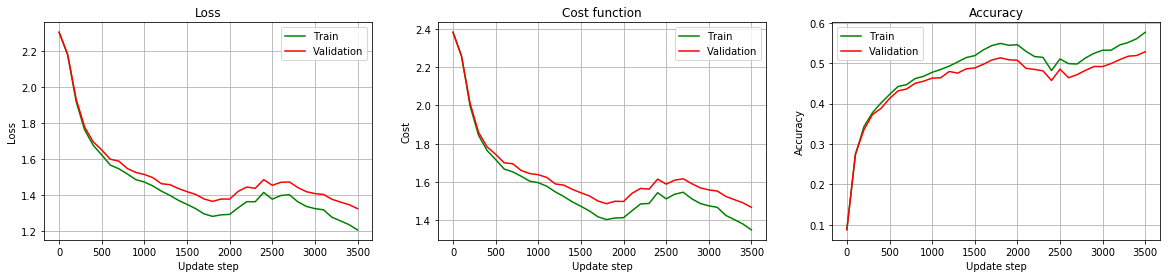

test_accuracy 0.5296
Randomly shuffling
Cyclical learning rate
total epochs 8
epoch 0


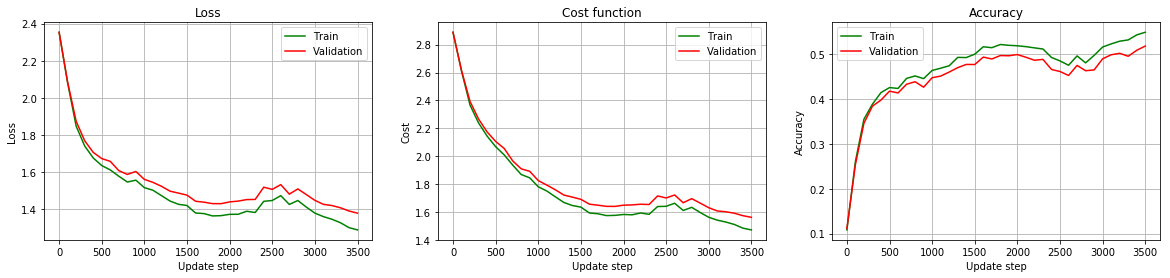

test_accuracy 0.5125
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
total epochs 8
epoch 0


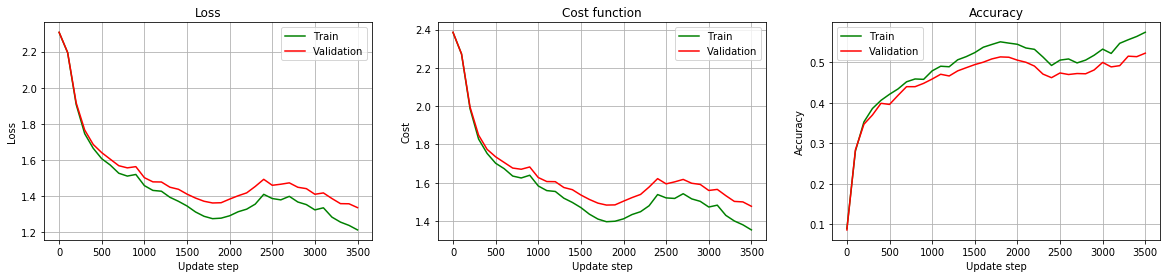

test_accuracy 0.5214
Randomly shuffling
Cyclical learning rate
total epochs 8
epoch 0


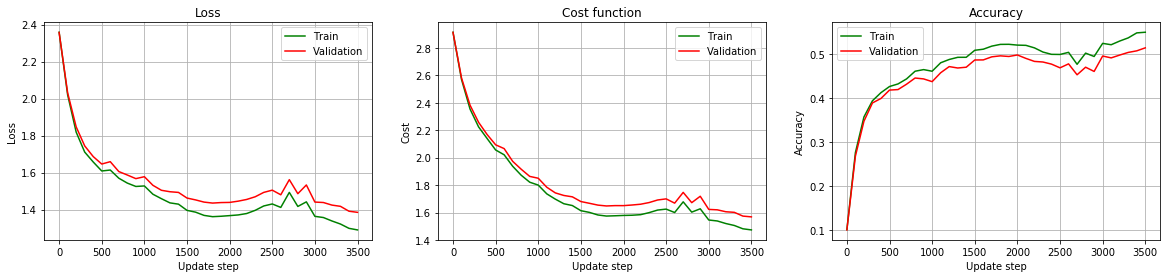

test_accuracy 0.5129
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
total epochs 8
epoch 0


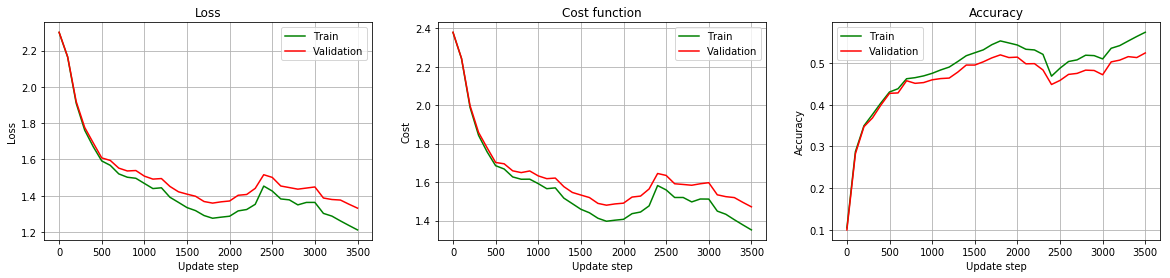

test_accuracy 0.5237
Randomly shuffling
Cyclical learning rate
total epochs 8
epoch 0


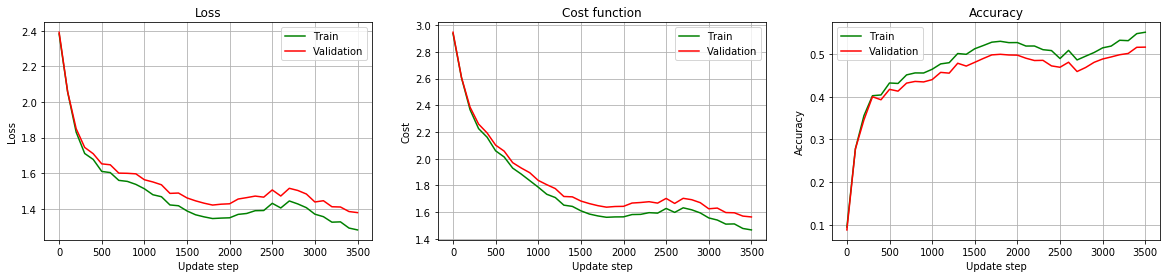

test_accuracy 0.5171


In [52]:
# batch norm with normally distributed initialisation
sigmas = [1e-1, 1e-3, 1e-4 ]
results = []
for sigma in sigmas:
    # train with and without batch normalisation
    params = {'lamda': 0.005, 'n_cycles':  2, 'batch_size': 100, 'hidden_nodes': [50, 50],
              'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 2 * 45000 / 100, 'batch_normalisation': True, \
             'sigmas': sigma, 'initialisation': 'normal'}
    res = sensitivity_experiments(params, datasets, plot_acc_costs=True)
    results.append({**params, **res})
    
    params = {'lamda': 0.005, 'n_cycles':  2, 'batch_size': 100, 'hidden_nodes': [50, 50],
              'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 2 * 45000 / 100, 'batch_normalisation': False, \
             'sigmas': sigma, 'initialisation': 'normal'}
    res = sensitivity_experiments(params, datasets, plot_acc_costs=True)
    results.append({**params, **res})

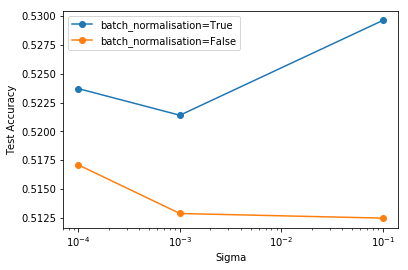

In [76]:
df_sensitivity = pd.DataFrame(results).sort_values(by=['test_accuracy', 'val_accuracy'], ascending=False)
df_sensitivity.to_csv('df_sensitivity.csv')

for batch_normalisation in [True, False]:
    df = df_sensitivity[df_sensitivity['batch_normalisation']==batch_normalisation].sort_values(by=['sigmas'], ascending=True)
    y = list(df['test_accuracy'])
    x = list(df['sigmas'])
#     x = np.log10(x)
    plt.plot(x, y, '-o', label=f'batch_normalisation={batch_normalisation}')

plt.xlabel('Sigma')
plt.xscale('log')
plt.legend()
plt.ylabel('Test Accuracy')  
plt.show()

## Optimising the network

Do a more thorough search to find a good network architecture. Does making the network deeper improve performance?

In [41]:
lamdas = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]

input_dim = train_X.shape[0]

# results = []
for i in range(3,12,2): # number of hidden layers
    for lamda in lamdas:
        params = {'n_cycles':  1, 'batch_size': 100, 'eta_min': 10**-5, 'eta_max': 0.1, \
                  'n_s': 5 * 45000 / 100, 'batch_normalisation': True, 'lamda': lamda, \
                 'hidden_nodes': [50]*i, 'number_layers': i+1}
        res = train_model(params, datasets, plot_acc_costs=False)
        print(res['test_accuracy'])
        results.append({**params, **res})
   

Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
total epochs 10
epoch 0
test_accuracy 0.5082
0.5082
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
total epochs 10
epoch 0
test_accuracy 0.4918
0.4918
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
total epochs 10
epoch 0
test_accuracy 0.4988
0.4988
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
total epochs 10
epoch 0
test_accuracy 0.4388
0.4388
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
total epochs 10
epoch 0
test_accuracy 0.4685
0.4685
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
total epochs 10
epoch 0
test_accuracy 0.3366
0.3366
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
total epochs 10
epoch 0
test_accuracy 0.4147
0.4147
Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
total epochs

In [36]:
train_model({'n_cycles':  1, 'batch_size': 100, 'eta_min': 10**-5, 'eta_max': 0.1, \
                  'n_s': 5 * 45000 / 100, 'batch_normalisation': True, 'lamda': 0.001, \
                 'hidden_nodes': [50]*12, \
              'number_layers': 2}, datasets)

Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
total epochs 10
epoch 0
test_accuracy 0.4857


{'test_accuracy': 0.4857, 'val_accuracy': 0.487}

Text(0, 0.5, 'Test Accuracy')

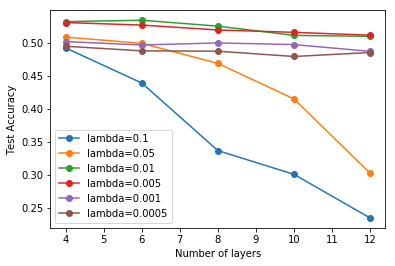

In [82]:
import pandas as pd
# df_exhaustive_search = pd.DataFrame(results).sort_values(by=['test_accuracy', 'val_accuracy'], ascending=False)
# df_exhaustive_search.to_csv('df_exhaustive_search.csv')
df_exhaustive_search = pd.read_csv('df_exhaustive_search.csv')
lamdas = [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005]
for lamda in lamdas:
    df = df_exhaustive_search[df_exhaustive_search['lamda']==lamda].sort_values(by=['number_layers'], ascending=True)
    y = list(df['test_accuracy'])
    x = list(df['number_layers'])
    plt.plot(x, y, '-o', label=f'lambda={lamda}')
plt.xlabel('Number of layers')
plt.legend()
plt.ylabel('Test Accuracy')  

#### Augment training data by applying small random geometric and photometric jitter to original training data

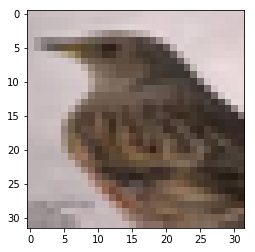

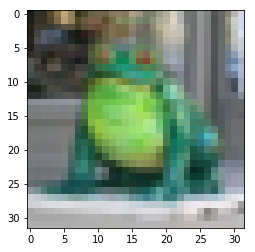

In [96]:
from PIL import Image

def display(image):
    ''' takes in image of shape (3072,) '''
    im = np.reshape(image,(3, 32,32))
    im = np.transpose(im, (1,2,0))
    plt.imshow(im)
    plt.show()
    
# Visualise random training image
display(train_X[:,18])
display(train_X[:,19])

In [8]:
def add_jitter(images, display=False, noise_level=0.01):
    D, N = images.shape
    ims = np.reshape(images, (3,32,32,N))
    ims = np.transpose(ims, (1,2,0,3))
    h, w, c, _ = ims.shape # (32,32,3)
    
#     noise = np.random.randint(0,noise_level,(h,w,c,N))
    noise = np.random.uniform(low=0, high=noise_level, size=(h,w,c,N))
    zitter = np.zeros_like(ims)
    zitter[:,:,:,:] = noise
    
    noise_added = ims + zitter

    combined = np.vstack((ims[:int(h/2),:,:,:], noise_added[int(h/2):,:,:,:]))
#     combined = np.where(combined > 255, 255, combined)
    
    
    if display:
        for i in range(N):
            plt.imshow(combined[:,:,:,i], interpolation='none')
            plt.show()
    
    combined_flattened = np.transpose(combined, (2,0,1,3))
    combined_flattened = combined_flattened.reshape(D,N)
    return combined_flattened

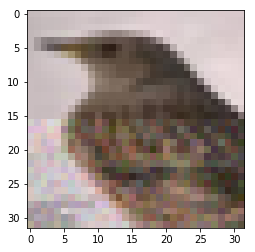

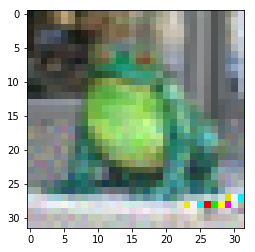

In [569]:
jittered_ims = add_jitter(train_X[:,18:20], display=True, noise_level=30)

Let us train a classifier with jitter

Performing batch normalisation True
Randomly shuffling
Adding jitter
Cyclical learning rate


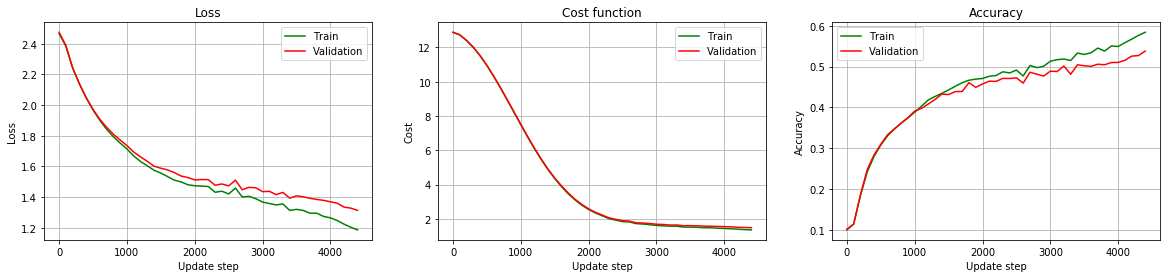

test_accuracy 0.5237


{'test_accuracy': 0.5237, 'val_accuracy': 0.5418}

In [572]:
# check performance for more cycles (3) with optimal lambda
params = {'lamda': 0.006669, 'n_cycles':  1, 'batch_size': 100, 'hidden_nodes': [50, 50],
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 5 * 45000 / 100, 'batch_normalisation': True,
         'apply_jitter': True}
train_model(params, datasets, plot_acc_costs=True)

Performing batch normalisation True
Randomly shuffling
Adding jitter
Cyclical learning rate


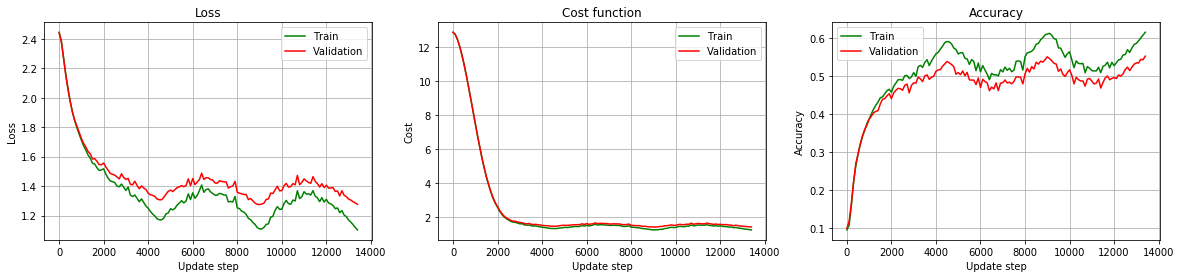

test_accuracy 0.538


{'test_accuracy': 0.538, 'val_accuracy': 0.5536}

In [574]:
# check performance for more cycles (3) with optimal lambda
params = {'lamda': 0.006669, 'n_cycles':  3, 'batch_size': 100, 'hidden_nodes': [50, 50],
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 5 * 45000 / 100, 'batch_normalisation': True,
         'apply_jitter': True}
train_model(params, datasets, plot_acc_costs=True)

#### Augment training set by adding new images with different levels of jitter, rotation to dataset


In [91]:
from skimage.transform import rotate

def rotate_images(images, labels, display=False):
    D, N = images.shape
    ims = np.reshape(images, (3,32,32,N))
    ims = np.transpose(ims, (1,2,0,3))
    h, w, c, _ = ims.shape # (32,32,3)
    
    rotated = []
    rotations = [90, 180, 270]
    rotated_labels = []
    
    for i in range(N):
        r = np.random.choice(rotations)
        rotated_im = rotate(ims[:,:,:,i], angle=r, resize=True)
        if display:
            plt.imshow(rotated_im, interpolation='none')
            plt.show()

        rotated.append(rotated_im)
        rotated_labels.append(labels[:,i])

    rotated = np.asarray(rotated)
    rotated_labels = np.asarray(rotated_labels).T
    
    rotated = np.transpose(rotated, (2,0,1,3))
    rotated = rotated.reshape(D,N)
    return rotated, rotated_labels

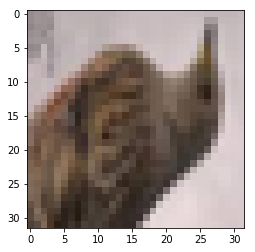

In [97]:
rotated = rotate_images(train_X[:,18:19], train_Y[:,18:19], True)

In [19]:
train_X_a = np.copy(train_X)
train_Y_a = np.copy(train_Y)

# rotate images on 10% of data
indices = np.random.choice([i for i in range(train_X_a.shape[1])], int(0.1*train_X_a.shape[1]), replace=False)
data_to_rotate = train_X_a[:,indices]
data_to_rotate_labels = train_Y_a[:,indices]
rotated_X, rotated_Y = rotate_images(data_to_rotate, data_to_rotate_labels)
# train_X_a = np.hstack((train_X_a, rotated_X))
# train_Y_a = np.hstack((train_Y_a, rotated_Y))


# take 5% of data and add jitter
indices = np.random.choice([i for i in range(train_X_a.shape[1])], int(0.05*train_X_a.shape[1]), replace=False)
data_to_jitter = train_X_a[:,indices]
jitter_labels = train_Y_a[:,indices]
jitter_data = add_jitter(data_to_jitter)

# take 50% of rotated data and add jitter
indices = np.random.choice([i for i in range(rotated_X.shape[1])], int(0.5*rotated_X.shape[1]), replace=False)
data_to_jitter = rotated_X[:,indices]
jitter_rotated_labels = rotated_Y[:,indices]
jitter_rotated_data = add_jitter(data_to_jitter)

train_X_a = np.hstack((train_X_a, rotated_X, jitter_data, jitter_rotated_data))
train_Y_a = np.hstack((train_Y_a, rotated_Y, jitter_labels, jitter_rotated_labels))

# randomly shuffle
indices = [i for i in range(train_X_a.shape[1])]
train_X_a = train_X_a[:,indices]
train_Y_a = train_Y_a[:,indices]

# new training set sizes
print(train_X_a.shape)
print(train_Y_a.shape)

np.save('augmented_data.npy', train_X_a)
np.save('augmented_labels.npy', train_Y_a)

(3072, 54000)
(10, 54000)


Performing batch normalisation True
Randomly shuffling
Cyclical learning rate
total epochs 30
epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29


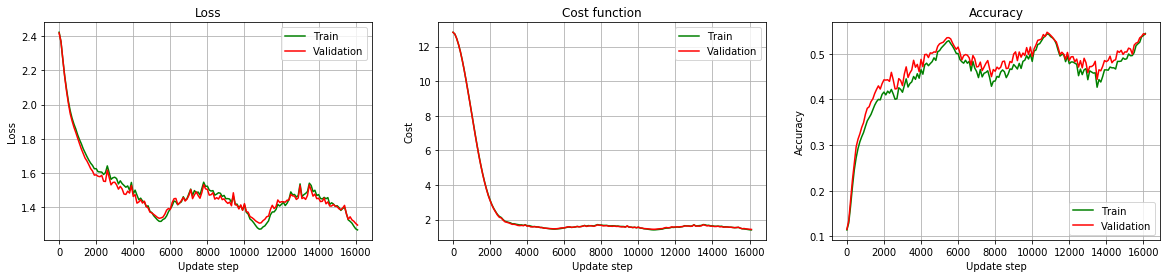

test_accuracy 0.5395


{'test_accuracy': 0.5395, 'val_accuracy': 0.5468}

In [22]:
train_X_a = np.load('augmented_data.npy')
train_Y_a = np.load('augmented_labels.npy')
# use augmented dataset in training
params = {'lamda': 0.006669, 'n_cycles':  3, 'batch_size': 100, 'hidden_nodes': [50, 50],
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 5 * 54000 / 100, 'batch_normalisation': True}
train_model(params, datasets=[train_X_a, train_Y_a, val_X, val_Y, test_X , test_Y], plot_acc_costs=True)

#### Apply dropout to your training if you have a high number of hidden nodes and you feel you need more regularization.

Performing batch normalisation True
Applying dropout p= 0.9
Applying dropout p= 0.9
Randomly shuffling
Cyclical learning rate
total epochs 30
epoch 0
epoch 10
epoch 20


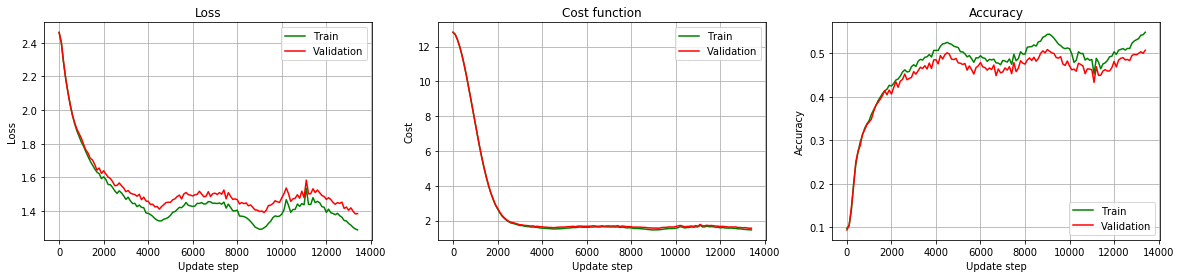

test_accuracy 0.5031


{'test_accuracy': 0.5031, 'val_accuracy': 0.5176}

In [48]:
params = {'lamda': 0.006669, 'n_cycles':  3, 'batch_size': 100, 'hidden_nodes': [50, 50], 'dropouts':[0.1,0.1],
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 5 * 45000 / 100, 'batch_normalisation': True}
train_model(params, datasets, plot_acc_costs=True)

Performing batch normalisation True
He
Applying dropout p= 0.95
He
Applying dropout p= 0.95
He
Randomly shuffling
Cyclical learning rate
total epochs 30
epoch 0
epoch 10
epoch 20


/Users/amritapanesar/KTH-Courses/Artificial-Neural-Networks/venv-anns/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


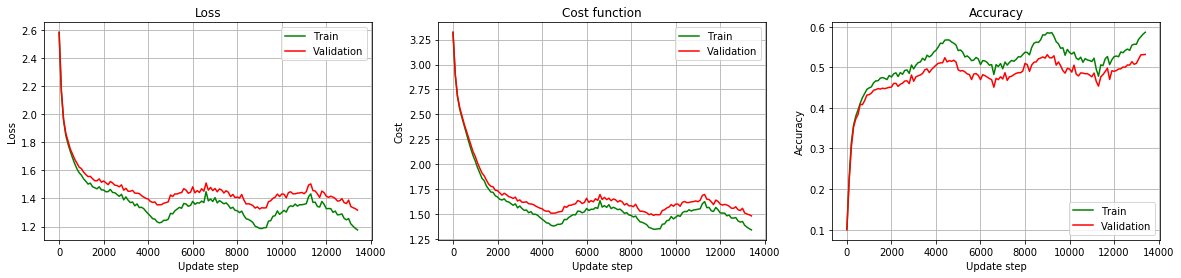

test_accuracy 0.5185


{'test_accuracy': 0.5185, 'val_accuracy': 0.5384}

In [84]:
params = {'lamda': 0.006669, 'n_cycles':  3, 'batch_size': 100, 'hidden_nodes': [50, 50], 'dropouts':[0.05,0.05],
          'eta_min': 10**-5, 'eta_max': 0.1, 'n_s': 5 * 45000 / 100, 'batch_normalisation': True}
train_model(params, datasets, plot_acc_costs=True)